In [1]:
%matplotlib inline
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from models.utils import loader

# Initialize CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   dog  deer  deer


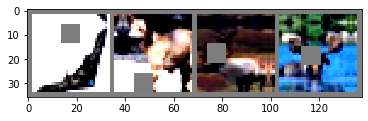

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(loader.trainloader_for_plot_alb)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
from models.A11 import Net

In [5]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Device: {device}")
net = Net().to(device)
summary(net, input_size=(3, 32, 32))

Device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
           Conv2d-13          [-1, 256, 16, 16]         294,912
        MaxPool2d-14      

In [6]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-7, momentum=0.9, weight_decay=0.01)

In [7]:
from models.utils import lr_finder

lr_finder = lr_finder.LRFinder(
    model=net,
    optimizer=optimizer,
    criterion=criterion,
    metric='accuracy',
    device=device)

lr_finder.range_test(
    train_loader=loader.trainloader_alb,
    end_lr=0.02,
    mode='epochs',
    num_iter=10,
    step_mode="linear")

  pip install torch-lr-finder -v --global-option="amp"



Learning rate search finished. See the graph with {finder_name}.plot()


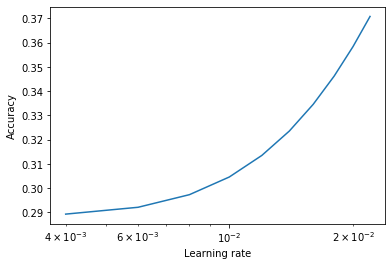

Best LR: 0.021999990000000004
Best Accuracy: 37.08%


In [8]:
lr_finder.plot()

best_accuracy = lr_finder.best_accuracy
best_lr = lr_finder.best_lr

print(f"Best LR: {best_lr}")
print(f"Best Accuracy: {best_accuracy * 100:0.2f}%")

lr_finder.reset()

In [9]:
from models.utils import train
from models.utils import test

In [10]:
from torch.optim.lr_scheduler import OneCycleLR

epochs = 24

optimizer = optim.SGD(net.parameters(), lr=best_lr, momentum=0.9, weight_decay=0.01)

scheduler = OneCycleLR(
    optimizer=optimizer,
    max_lr=best_lr,
    epochs=epochs,
    steps_per_epoch=len(loader.trainloader_alb),
    pct_start=5/epochs,
    div_factor=10,
    final_div_factor=10
)

last_epoch = False

train_losses = []
train_acc = []
test_acc = []
test_losses = []

for epoch in range(epochs):
    train.train(net, device, loader.trainloader_alb, optimizer, criterion, epoch, train_acc , train_losses)
    if epoch == epochs - 1:
        last_epoch = True
    test.test(net, device, loader.testloader, criterion, last_epoch, test_acc, test_losses)
    scheduler.step(test_losses[-1])

Epoch= 0 Loss=2.0696353912353516 Batch_id=97 Accuracy=29.49: 100%|█████████████████████| 98/98 [00:51<00:00,  1.91it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0041, Accuracy: 3865/10000 (38.65%)



Epoch= 1 Loss=1.9788835048675537 Batch_id=97 Accuracy=44.92: 100%|█████████████████████| 98/98 [00:51<00:00,  1.90it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0039, Accuracy: 4905/10000 (49.05%)



Epoch= 2 Loss=1.8833539485931396 Batch_id=97 Accuracy=53.24: 100%|█████████████████████| 98/98 [00:51<00:00,  1.92it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0037, Accuracy: 5909/10000 (59.09%)



Epoch= 3 Loss=1.806513786315918 Batch_id=97 Accuracy=60.94: 100%|██████████████████████| 98/98 [00:51<00:00,  1.91it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0036, Accuracy: 6492/10000 (64.92%)



Epoch= 4 Loss=1.8241864442825317 Batch_id=97 Accuracy=65.70: 100%|█████████████████████| 98/98 [00:51<00:00,  1.91it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0036, Accuracy: 6796/10000 (67.96%)



Epoch= 5 Loss=1.780549168586731 Batch_id=97 Accuracy=69.37: 100%|██████████████████████| 98/98 [00:51<00:00,  1.92it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0035, Accuracy: 7247/10000 (72.47%)



Epoch= 6 Loss=1.75436532497406 Batch_id=97 Accuracy=72.01: 100%|███████████████████████| 98/98 [00:51<00:00,  1.90it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0035, Accuracy: 7233/10000 (72.33%)



Epoch= 7 Loss=1.7121260166168213 Batch_id=97 Accuracy=74.21: 100%|█████████████████████| 98/98 [00:51<00:00,  1.91it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0034, Accuracy: 7493/10000 (74.93%)



Epoch= 8 Loss=1.7708895206451416 Batch_id=97 Accuracy=75.49: 100%|█████████████████████| 98/98 [00:51<00:00,  1.90it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0034, Accuracy: 7701/10000 (77.01%)



Epoch= 9 Loss=1.684656023979187 Batch_id=97 Accuracy=77.32: 100%|██████████████████████| 98/98 [00:51<00:00,  1.91it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0034, Accuracy: 7747/10000 (77.47%)



Epoch= 10 Loss=1.6701583862304688 Batch_id=97 Accuracy=78.45: 100%|████████████████████| 98/98 [00:51<00:00,  1.90it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0034, Accuracy: 7872/10000 (78.72%)



Epoch= 11 Loss=1.698854684829712 Batch_id=97 Accuracy=79.82: 100%|█████████████████████| 98/98 [00:51<00:00,  1.90it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0033, Accuracy: 8073/10000 (80.73%)



Epoch= 12 Loss=1.7200742959976196 Batch_id=97 Accuracy=80.75: 100%|████████████████████| 98/98 [00:51<00:00,  1.92it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0033, Accuracy: 8050/10000 (80.50%)



Epoch= 13 Loss=1.6679353713989258 Batch_id=97 Accuracy=81.69: 100%|████████████████████| 98/98 [00:51<00:00,  1.90it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0033, Accuracy: 8238/10000 (82.38%)



Epoch= 14 Loss=1.656949520111084 Batch_id=97 Accuracy=82.16: 100%|█████████████████████| 98/98 [00:51<00:00,  1.89it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0034, Accuracy: 7899/10000 (78.99%)



Epoch= 15 Loss=1.666682243347168 Batch_id=97 Accuracy=83.13: 100%|█████████████████████| 98/98 [00:51<00:00,  1.89it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0033, Accuracy: 8275/10000 (82.75%)



Epoch= 16 Loss=1.6210618019104004 Batch_id=97 Accuracy=83.46: 100%|████████████████████| 98/98 [00:51<00:00,  1.91it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0033, Accuracy: 8325/10000 (83.25%)



Epoch= 17 Loss=1.611371397972107 Batch_id=97 Accuracy=84.43: 100%|█████████████████████| 98/98 [00:51<00:00,  1.90it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0033, Accuracy: 8231/10000 (82.31%)



Epoch= 18 Loss=1.6490856409072876 Batch_id=97 Accuracy=85.22: 100%|████████████████████| 98/98 [00:51<00:00,  1.91it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0033, Accuracy: 8405/10000 (84.05%)



Epoch= 19 Loss=1.5985746383666992 Batch_id=97 Accuracy=85.49: 100%|████████████████████| 98/98 [00:51<00:00,  1.90it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0033, Accuracy: 8428/10000 (84.28%)



Epoch= 20 Loss=1.6171839237213135 Batch_id=97 Accuracy=86.02: 100%|████████████████████| 98/98 [00:51<00:00,  1.90it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0033, Accuracy: 8415/10000 (84.15%)



Epoch= 21 Loss=1.6097911596298218 Batch_id=97 Accuracy=86.61: 100%|████████████████████| 98/98 [00:51<00:00,  1.90it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0032, Accuracy: 8520/10000 (85.20%)



Epoch= 22 Loss=1.6233516931533813 Batch_id=97 Accuracy=86.93: 100%|████████████████████| 98/98 [00:51<00:00,  1.90it/s]
  0%|                                                                                           | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0032, Accuracy: 8584/10000 (85.84%)



Epoch= 23 Loss=1.6028398275375366 Batch_id=97 Accuracy=87.23: 100%|████████████████████| 98/98 [00:51<00:00,  1.91it/s]



Validation set: Average loss: 0.0033, Accuracy: 8439/10000 (84.39%)



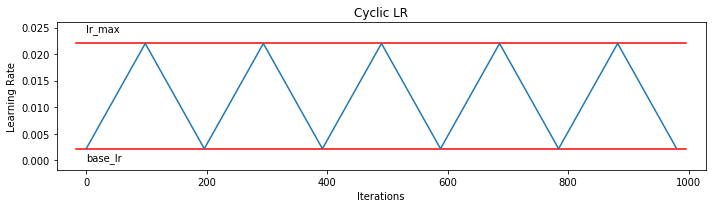

In [11]:
from models.utils.cyclic_lr import CustomCyclicLR

triangular_lr = CustomCyclicLR(
    base_lr=best_lr/10, 
    max_lr=best_lr,
    step_size=len(loader.trainloader_alb),
    iterations=len(loader.trainloader_alb) * 10)

triangular_lr.cyclic_lr(plot=True)

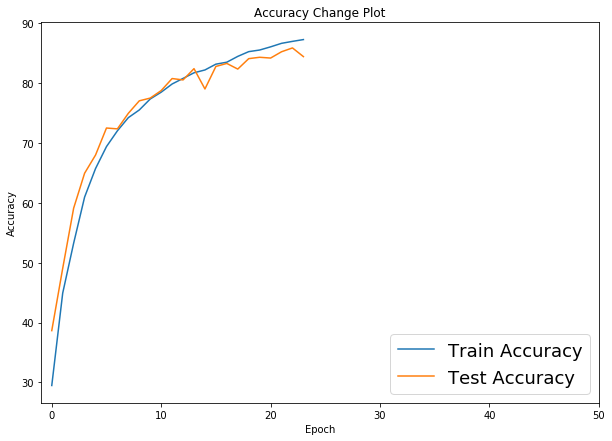

In [12]:
acc_fig, axs = plt.subplots(1,1,figsize=(10,7))
axs.set_xlim([-1, 50])
axs.plot(train_acc, label='Train Accuracy')
axs.plot(test_acc, label='Test Accuracy')
axs.set_title("Accuracy Change Plot")
axs.set_xlabel("Epoch")
axs.set_ylabel("Accuracy")
axs.legend(loc='lower right', prop={'size': 18})

acc_fig.savefig('accuracy_change_plot.jpg')